In [223]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
%autoreload 2
from data import TimeSeriesDataset, TimeSeriesConv1dDataset, TimeSeriesNstepsDataset

import lightning as pl
from torch.utils.data import DataLoader
import torch.nn.functional as F 
import torchmetrics as tm

from single_step_models import TimeSeriesLstmRegression, TimeSeriesConv1dRegression
from nsteps_models import TimeSeriesFcRegressionN

import yaml
from utils import *
from pathlib import Path
from warnings import filterwarnings
import seaborn as sns

filterwarnings(action='ignore', category=pl.pytorch.utilities.warnings.PossibleUserWarning)
sns.set()

### 01. Lukoil stock price prediction

In [225]:
path = Path('./data')

augm_path = sorted(path.glob("a*"))[0]
lpaths = sorted(path.glob("L*"))


CONFIG = yaml.safe_load(open('config.yaml'))

#### 01.1 Data processing

In [4]:
timeseries = TimeSeriesDataset(paths=lpaths, 
                               augm_path=augm_path,
                               window_len=3)

In [30]:
train_dataset, test_dataset = time_series_split(timeseries, 
                                                test_size=CONFIG['data']['test_size'])

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

#### 01.2 LSTM Training

In [11]:
net = TimeSeriesLstmRegression(**CONFIG['model']['rnn'])
trainer = pl.Trainer(max_epochs=CONFIG['training']['n_epochs'])

In [7]:
trainer.fit(net, 
            train_dataloaders=train_loader,
            val_dataloaders=test_loader)

In [8]:
train_predictions = trainer.predict(net, train_loader) 
test_predictions = trainer.predict(net, test_loader) 

In [9]:
plt.figure(figsize=(18,6))
plot_real_and_predictions(test_dataset, train_dataset,
                          train_predictions, test_predictions)

In [10]:
trainer.validate(net, dataloaders=test_loader)

#### 01.3 Conv1d Training

In [39]:
timeseries_panel = TimeSeriesConv1dDataset(lpaths, 
                                           augm_path, 
                                           window_len=14)

train_dataset, test_dataset = time_series_split(timeseries_panel, 
                                                test_size=CONFIG['data']['test_size'])

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [40]:
trainer = pl.Trainer(max_epochs=100)
net = TimeSeriesConv1dRegression(**CONFIG['model']['conv'], loss=F.mse_loss)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(net, train_dataloaders=train_loader,
            val_dataloaders=test_loader
            )

In [42]:
train_predictions = trainer.predict(net, train_loader) 
test_predictions = trainer.predict(net, test_loader) 

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

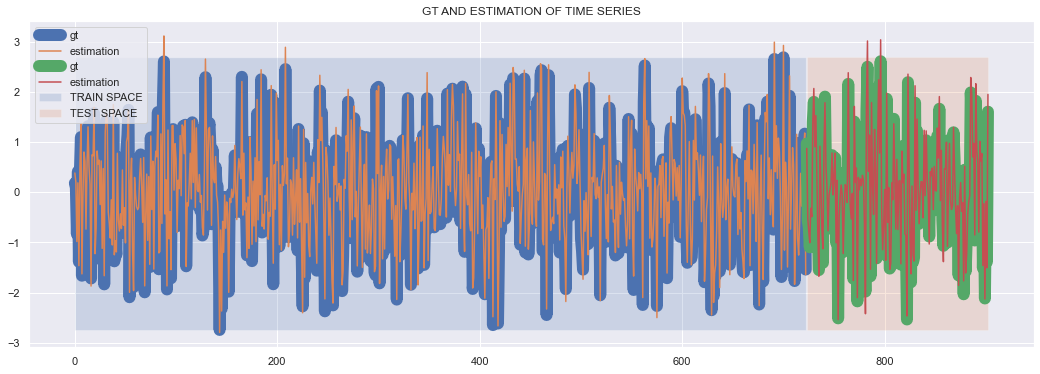

In [43]:
plt.figure(figsize=(18,6))
plot_real_and_predictions(test_dataset, train_dataset,
                          train_predictions, test_predictions)

In [44]:
trainer.validate(net, dataloaders=[test_loader])

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.14790226519107819    │
│            mse            │    0.03633264824748039    │
│         r2_score          │    0.9547138810157776     │
└───────────────────────────┴───────────────────────────┘

[{'r2_score': 0.9547138810157776,
  'mse': 0.03633264824748039,
  'mae': 0.14790226519107819}]

#### 01.4 FC Training [nsteps]

In [229]:
timeseries_nstep = TimeSeriesNstepsDataset(paths=lpaths, 
                                           augm_path=augm_path,
                                           window_len=10)

In [230]:
train_dataset, test_dataset = time_series_split(timeseries_nstep, 
                                                test_size=0.02)

train_loader = DataLoader(train_dataset, 
                          batch_size=CONFIG['data']['train_batch_size'],
                          shuffle=CONFIG['data']['shuffle'],
                          drop_last=False)

test_loader = DataLoader(test_dataset, 
                         batch_size=CONFIG['data']['test_batch_size'],
                         shuffle=CONFIG['data']['shuffle'], 
                         drop_last=False)

In [231]:
net = TimeSeriesFcRegressionN(**CONFIG['model']['fc_nstep'])
trainer = pl.Trainer(max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [232]:
trainer.fit(net, 
            train_dataloaders=train_loader)


  | Name      | Type       | Params
-----------------------------------------
0 | regressor | Sequential | 286 K 
-----------------------------------------
286 K     Trainable params
0         Non-trainable params
286 K     Total params
1.146     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [234]:
trainer.validate(net, 
                 dataloaders=test_loader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │   0.023699689656496048    │
│            mse            │   0.0010313753737136722   │
└───────────────────────────┴───────────────────────────┘

[{'mse': 0.0010313753737136722, 'mae': 0.023699689656496048}]

In [235]:
test_predictions = trainer.predict(net, test_loader)
test_predictions = torch.cat(test_predictions)

Predicting: 0it [00:00, ?it/s]

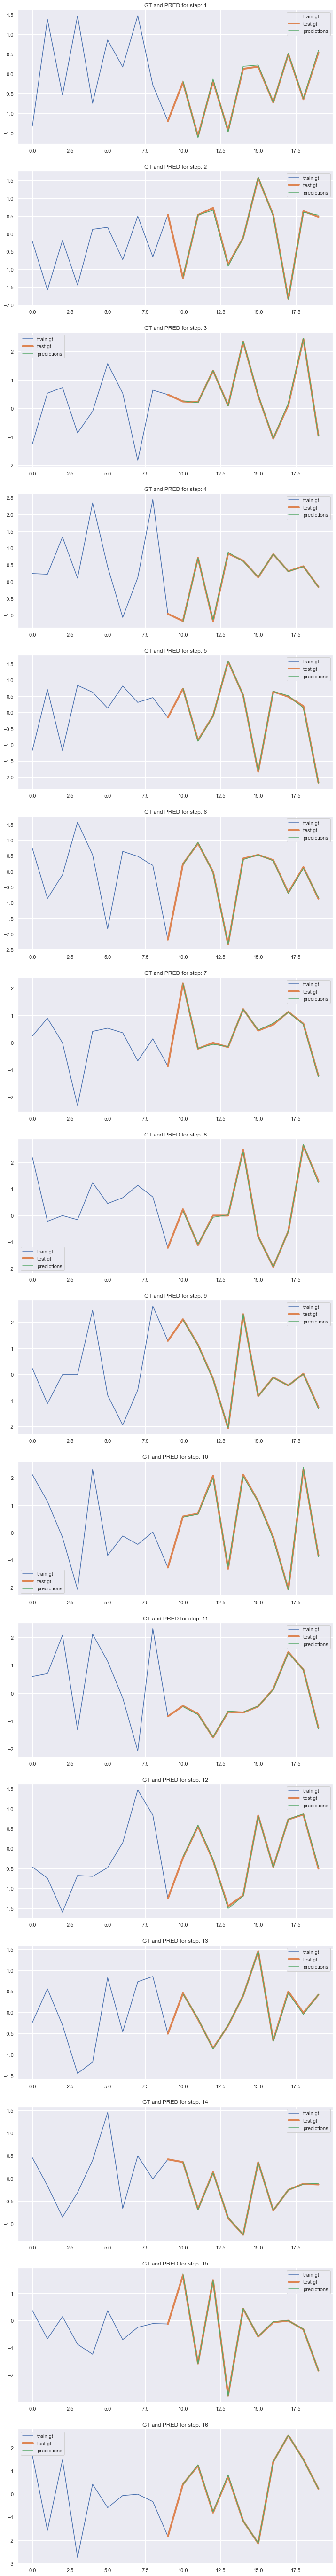

In [227]:
plot_nstep_real_and_predictions(test_dataset, test_predictions)

#### 01.5 LSTM Training [nsteps]